In [159]:
import sys
import os
sys.path.append('C:\\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization') #OSCAR path
sys.path.append('C:\\Users\\benny\\Documents\\Preliminary-project')  #BENJAMIN path
sys.path.append('C:\\Users\\Epsilon Delta\\OneDrive - NTNU\\Energi og Miljø NTNU\\Høst2023\\TET4565 Fordypningsemne\\Hydro_optimization') #ESPEN path

import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
from pyomo.util.infeasible import log_infeasible_constraints
import matplotlib.pyplot as plt
from calculations.datahandling import*
from calculations.data_processor import* 

## Data handling

In [160]:
# ---------------------------- Read in parameters and hydro topology -------------------------------------- # WE WAIT WITH THIS UNTIL LATER

def InputData(data_file):
    inputdata = pd.read_excel(data_file)
    inputdata = inputdata.set_index('Parameter', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['prod'] = inputdata[['Ci', 'yi', 'P_min', 'P_max']]
    data['prod'].drop('Solar', inplace=True)
    return data

parameters=InputData('data/Parameters.xlsx')


def InputData(data_file):
    inputdata = pd.read_excel(data_file, sheet_name='Hydro')
    inputdata = inputdata.set_index('Ormsetfoss', drop=True)
    inputdata = inputdata.transpose()
    data = {}
    data['ormset'] = inputdata[['Pmin', 'Pmax','Vmax','Vmin','Vstart','Qmin','Qmax','Q','LRL','HRL','RL_start']].dropna()

    #Volume-head relationship:
    inputdata = pd.read_excel(data_file, sheet_name='Vol_head')
    data_volhead = {}
    data_volhead['ormset_headvol'] = inputdata[['Mm3','m']].dropna()

    #Flow-head relationship:
    inputdata = pd.read_excel(data_file, sheet_name='flow')
    data_flowhead = {}
    data_flowhead['ormset_headflow'] = inputdata[['Moh','m3/s']].dropna()
    return data

topology = InputData('data/Ormset_Data.xlsx')

display(topology)

{'ormset': Ormsetfoss  Pmin  Pmax  Vmax  Vmin  Vstart  Qmin  Qmax  Q  LRL  HRL  RL_start
 Hydro1         0    43    45     0      45     2    12  4  375  388       388
 Hydro2         0    30    20     0      20     2    12  2  326  331       331}

In [161]:
start = '2018-01-01 00:00:00'
end = '2018-01-01 23:00:00'

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H',columns)
#combined_inflow = {key: value for inner_dict in inflow.values() for key, value in inner_dict.items()}
display(inflow)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2


[{1: 0.8,
  2: 0.0,
  3: 0.0,
  4: 0.86,
  5: 15.63,
  6: 0.0,
  7: 0.76,
  8: 0.76,
  9: 1.98,
  10: 0.76,
  11: 0.76,
  12: 0.76,
  13: 1.98,
  14: 0.76,
  15: 0.76,
  16: 1.98,
  17: 0.76,
  18: 0.76,
  19: 0.76,
  20: 1.92,
  21: 0.76,
  22: 0.76,
  23: 1.98,
  24: 0.0},
 {1: 0.08,
  2: 0.0,
  3: 0.0,
  4: 0.08,
  5: 1.48,
  6: 0.0,
  7: 0.07,
  8: 0.07,
  9: 0.19,
  10: 0.07,
  11: 0.07,
  12: 0.07,
  13: 0.19,
  14: 0.07,
  15: 0.07,
  16: 0.19,
  17: 0.07,
  18: 0.07,
  19: 0.07,
  20: 0.18,
  21: 0.07,
  22: 0.07,
  23: 0.19,
  24: 0.0}]

## Digital twin model to hydro power plant

dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key : Value


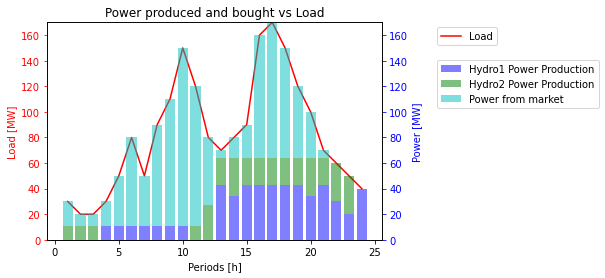

Objective Value: 873.911192084616
Model unknown

  Variables:
    p : Size=48, Index=p_index
        Key            : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Hydro1', 1) :     0 :                0.0 :    43 : False : False :  Reals
         ('Hydro1', 2) :     0 :                0.0 :    43 : False : False :  Reals
         ('Hydro1', 3) :     0 :                0.0 :    43 : False : False :  Reals
         ('Hydro1', 4) :     0 :           10.71252 :    43 : False : False :  Reals
         ('Hydro1', 5) :     0 :           10.71252 :    43 : False : False :  Reals
         ('Hydro1', 6) :     0 :           10.71252 :    43 : False : False :  Reals
         ('Hydro1', 7) :     0 :           10.71252 :    43 : False : False :  Reals
         ('Hydro1', 8) :     0 :           10.71252 :    43 : False : False :  Reals
         ('Hydro1', 9) :     0 :           10.71252 :    43 : False : False :  Reals
        ('Hydro1', 10) :     0 :           10.71252 :    

In [162]:
#Definitions
start = '2018-01-01 00:00:00'
end = '2018-01-01 23:00:00'


# Define your input data and constants
L = {1: 30, 2: 20, 3: 20, 4: 30, 5: 50, 6: 80, 7: 50, 8: 90, 9: 110, 10: 150, 11: 120, 12: 80, 13: 70, 14: 80, 15: 90, 16: 160, 17: 170, 18: 150, 19: 120, 20: 100, 21: 70, 22: 60, 23: 50, 24: 40}

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'H': 300}

# Create a ConcreteModel
model = pyo.ConcreteModel()

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN



# Sets to model hydro topology
model.periods = pyo.Set(initialize=range(1, 25, 1))                   #these sets must be defined in the latex report as well
model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
model.market = pyo.Set(initialize=['DAM'])

# Hydro parameters
fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
model.eff = pyo.Param(initialize=constants['eff'])
model.rho = pyo.Param(initialize=constants['rho'])
model.g = pyo.Param(initialize=constants['g'])
model.H = pyo.Param(initialize=constants['H'])

# Cost parameters
Fi=1000
model.Fi=pyo.Param(model.market, initialize=Fi)                  #Buy-in market price (initial market price cost)
model.Mi = pyo.Param(model.periods, initialize=market_prices_h)            #Market price varying
model.Ci=pyo.Param(model.plants, initialize=parameters['prod']['Ci'])  #Initial cost for plants
model.yi=pyo.Param(model.plants, initialize=parameters['prod']['yi'])  #Variable costs for plants 

#Plant parameters
model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

#Topology parameters
model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
#model.inflow = pyo.Param(model.periods, initialize=inflow)
model.inflow1 = pyo.Param(model.periods, initialize=inflow_hydro1)
model.inflow2 = pyo.Param(model.periods, initialize=inflow_hydro2)

# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])
model.p = pyo.Var(model.plants, model.periods, bounds=p_bounds)               #Power production

model.m = pyo.Var(model.market, model.periods, within=NonNegativeReals)       #Power from market

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])
model.q = pyo.Var(model.plants, model.periods, bounds=q_bounds)          #time dependent discharge which varies based on power production

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])
model.v = pyo.Var(model.plants, model.periods, bounds=vol_bounds)        #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)


#def wl_bounds(model, i, j): #water level
#    return (model.LRL[i], model.HRL[i])
#model.h = pyo.Var(model.plants, model.periods, bounds=wl_bounds)                  #time dependent water level which vares based on volume (HEAD)


#-------------------MODEL OF RESERVOIRS------------------#
model.cumulative_q = pyo.Var(model.plants, model.periods, within=pyo.NonNegativeReals)           #combining discharge (q [m3/s]) into m3 over given timeframe (NEED TO CHECK CONVERSIONS)
# Constraint to calculate the cumulative sum of discharges (WATER OUT OF PLANTS)
def cumulative_q_rule(model, i, j):
    if j == 1:
        return model.cumulative_q[i, j] == model.q[i, j]
    else:
        return model.cumulative_q[i, j] == model.cumulative_q[i, j - 1] + model.q[i, j]
model.cumulative_q_cons = pyo.Constraint(model.plants, model.periods, rule=cumulative_q_rule)
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])
def volume_change_rule(model, i, j):
    if j == 1:
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (sum(model.cumulative_q[i, j] for i in model.plants)*fm3) + (model.inflow1[j]*fm3) + (model.inflow2[j]*fm3)
        elif i == 'Hydro2':
            # Include the discharge from Hydro1 as inflow to Hydro2
            return model.v[i, j] == (model.v0[i]) - (sum(model.cumulative_q[i, j] for i in model.plants)*fm3) + (model.inflow2[j]*fm3) + (model.cumulative_q['Hydro1', j]*fm3)
    else:
        if i == 'Hydro1':
            return model.v[i, j] == (model.v[i, j - 1]) - (sum(model.cumulative_q[i, j] for i in model.plants)*fm3) + (model.inflow1[j]*fm3) + (model.inflow2[j]*fm3)
        elif i == 'Hydro2':
            # Include the discharge from Hydro1 as inflow to Hydro2
            return model.v[i, j] == (model.v[i, j - 1]) - (sum(model.cumulative_q[i, j] for i in model.plants)*fm3) + (model.inflow2[j]*fm3) + (model.cumulative_q['Hydro1', j]*fm3)

model.volume_change_cons = pyo.Constraint(model.plants, model.periods, rule=volume_change_rule)

# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j] + model.m['DAM',j] == L[j]
model.load_cons = pyo.Constraint(model.periods, rule=load_rule)

def power_rule(model, j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return sum(10**-6*model.eff * model.rho * model.g * model.H * model.q[i, j] for i in model.plants) == sum(model.p[i,j] for i in model.plants) #MW
model.power_prod = pyo.Constraint(model.periods, rule=power_rule)

def vol_rule(model, i):
    tolerance = 1e1  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, max(model.periods)] >= model.v0[i] - tolerance
model.volume_end = pyo.Constraint(model.plants, rule=vol_rule)

# Objective function
def ObjRule(model):
    return sum(model.p[i, j] for i in model.plants for j in model.periods)

model.obj = pyo.Objective(rule=ObjRule, sense=pyo.maximize)

# Solve the model
opt = pyo.SolverFactory('gurobi', solver_io="python") 
results = opt.solve(model)

#defining dual 
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
model.dual.display()

# Check if the solution is optimal
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    power_production = {(plant, period): model.p[plant, period].value for plant in model.plants for period in model.periods}
    market_power = {(market, period): model.m[market, period].value for market in model.market for period in model.periods}
    load_values = [L[j] for j in model.periods]
    colors = ['b', 'g', 'c']  # Add 'c' for the market

    fig, ax1 = plt.subplots()
    ax1.plot(model.periods, load_values, 'r-', label='Load')
    ax1.set_xlabel('Periods [h]')
    ax1.set_ylabel('Load [MW]', color='r')
    ax1.tick_params('y', colors='r')
    ax2 = ax1.twinx()
    ax1.set_ylim([0, max(load_values)])  # Adjust the upper limit as needed
    ax2.set_ylim([0, max(load_values)])  # Adjust the upper limit as needed


    bottom = np.zeros(len(model.periods))  # Initialize the bottom position for stacking

    for i, plant in enumerate(model.plants):
        power_values = [power_production[plant, period] for period in model.periods]
        ax2.bar(model.periods, power_values, color=colors[i], alpha=0.5, label=f'{plant} Power Production', bottom=bottom)
        bottom += power_values  # Update the bottom position for the next set of bars

    market_power_values = [market_power['DAM', period] for period in model.periods]
    ax2.bar(model.periods, market_power_values, color='c', alpha=0.5, label='Power from market', bottom=bottom)

    ax2.set_ylabel('Power [MW]', color='b')
    ax2.tick_params('y', colors='b')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))
    plt.title('Power produced and bought vs Load')
    plt.show()
    print("Objective Value:", pyo.value(model.obj))
else:
    log_infeasible_constraints(model)
    print("Solver did not find an optimal solution.")
model.display()


# Display the model specifics
print()
model.pprint()
print()
#model.constraint.pprint()
print()
model.obj.display()
print()


dual : Direction=Suffix.IMPORT, Datatype=Suffix.FLOAT
    Key : Value


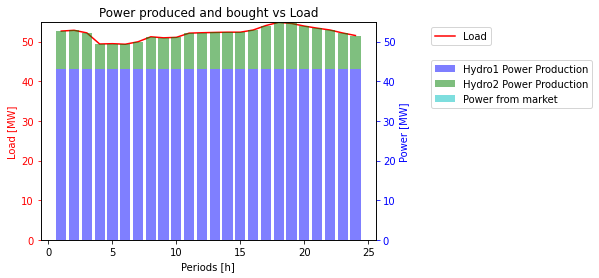

Objective Value: 1251.0200000000004
Model unknown

  Variables:
    p : Size=48, Index=p_index
        Key            : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Hydro1', 1) :     0 :               43.0 :    43 : False : False :  Reals
         ('Hydro1', 2) :     0 :               43.0 :    43 : False : False :  Reals
         ('Hydro1', 3) :     0 :               43.0 :    43 : False : False :  Reals
         ('Hydro1', 4) :     0 :               43.0 :    43 : False : False :  Reals
         ('Hydro1', 5) :     0 :               43.0 :    43 : False : False :  Reals
         ('Hydro1', 6) :     0 :               43.0 :    43 : False : False :  Reals
         ('Hydro1', 7) :     0 :               43.0 :    43 : False : False :  Reals
         ('Hydro1', 8) :     0 :               43.0 :    43 : False : False :  Reals
         ('Hydro1', 9) :     0 :               43.0 :    43 : False : False :  Reals
        ('Hydro1', 10) :     0 :               43.0 :  

In [166]:
#Definitions
start = '2018-01-01 00:00:00'
end = '2018-01-01 23:00:00'
start_dt = pd.to_datetime(start)
end_dt = pd.to_datetime(end)

# Define your input data and constants
#L = {1: 30, 2: 20, 3: 20, 4: 30, 5: 50, 6: 80, 7: 50, 8: 90, 9: 110, 10: 150, 11: 120, 12: 80, 13: 70, 14: 80, 15: 90, 16: 160, 17: 170, 18: 150, 19: 120, 20: 100, 21: 70, 22: 60, 23: 50, 24: 40}

constants = {'eff': 0.91, 'rho': 1000, 'g': 9.81, 'H': 300}

# Create a ConcreteModel
model = pyo.ConcreteModel()

#Input data and read-in
input_data_market = read_csv_data('data/Market_price.csv')              #MARKET
market_prices_h=convert_to_dict(input_data_market, start, end, 'H') ##avg_market_price=average_value(market_prices_h)
avg_market_price=average_value(market_prices_h)

input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn','Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H', columns)
inflow_hydro1 = inflow[0]  # First dictionary for Hydro1 - ORMSETVATN
inflow_hydro2 = inflow[1]  # Second dictionary for Hydro2 - BUAVATN



# Sets to model hydro topology
hours_difference = ((end_dt - start_dt).total_seconds() / 3600)+1  # 3600 seconds in an hour
model.periods = pyo.Set(initialize=range(1, int(hours_difference) + 1, 1))
#model.periods = pyo.Set(initialize=range(1, 25, 1))                   #these sets must be defined in the latex report as well
model.plants = pyo.Set(initialize=['Hydro1', 'Hydro2'])               #uses i
model.market = pyo.Set(initialize=['DAM'])

# Hydro parameters
fm3 = 3600/1000000 # Conversion factor between m^3/s and Mm^3/hour. 1h = 3600s and M = 10^6.
model.eff = pyo.Param(initialize=constants['eff'])
model.rho = pyo.Param(initialize=constants['rho'])
model.g = pyo.Param(initialize=constants['g'])
#model.H = pyo.Param(initialize=constants['H']) --> convert to variable

# Cost parameters
Fi=1000
#max_purchase_limit = 100  # Adjust this value as needed
model.Fi=pyo.Param(model.market, initialize=Fi)                  #Buy-in market price (initial market price cost)
#model.PurchaseLimit = pyo.Param(initialize=max_purchase_limit)
model.Mi = pyo.Param(model.periods, initialize=avg_market_price)            #Market price varying
model.Ci=pyo.Param(model.plants, initialize=parameters['prod']['Ci'])  #Initial cost for plants
model.yi=pyo.Param(model.plants, initialize=parameters['prod']['yi'])  #Variable costs for plants 

#Plant parameters
model.Pmin=pyo.Param(model.plants, initialize=topology['ormset']['Pmin'])
model.Pmax=pyo.Param(model.plants, initialize=topology['ormset']['Pmax'])

#Load parameters
model.L = pyo.Param(model.periods, initialize={j: 2* market_prices_h[j] for j in model.periods})

#Topology parameters
model.Qmin=pyo.Param(model.plants, initialize=topology['ormset']['Qmin']) 
model.Qmax=pyo.Param(model.plants, initialize=topology['ormset']['Qmax'])
model.Vmin=pyo.Param(model.plants, initialize=topology['ormset']['Vmin'])
model.Vmax=pyo.Param(model.plants, initialize=topology['ormset']['Vmax'])
model.v0 = pyo.Param(model.plants, initialize=topology['ormset']['Vstart'])
model.LRL =pyo.Param(model.plants, initialize=topology['ormset']['LRL'])
model.HRL =pyo.Param(model.plants, initialize=topology['ormset']['HRL'])
#model.inflow = pyo.Param(model.periods, initialize=inflow)
model.inflow1 = pyo.Param(model.periods, initialize=inflow_hydro1)
model.inflow2 = pyo.Param(model.periods, initialize=inflow_hydro2)


# Variables for power produced or bought and volume, water level etc.
def p_bounds(model, i, j):
    return (model.Pmin[i], model.Pmax[i])
model.p = pyo.Var(model.plants, model.periods, bounds=p_bounds)               #Power production

model.m = pyo.Var(model.market, model.periods, within=NonNegativeReals)       #Power from market

def q_bounds(model, i, j): #flow rate
    return (model.Qmin[i], model.Qmax[i])
model.q = pyo.Var(model.plants, model.periods, bounds=q_bounds)          #time dependent discharge which varies based on power production

def vol_bounds(model, i, j):
    return (model.Vmin[i], model.Vmax[i])
model.v = pyo.Var(model.plants, model.periods, bounds=vol_bounds)        #time dependent volume which varies based on discharge over time (convert from m3/s to MM3/day ellerno og subtraher)

def head_bounds(model,i,j):
    return (model.LRL[i], model.HRL[i])
model.h = pyo.Var(model.plants, model.periods, bounds=head_bounds)

#def market_bounds(model, n ,j):

#def wl_bounds(model, i, j): #water level
#    return (model.LRL[i], model.HRL[i])
#model.h = pyo.Var(model.plants, model.periods, bounds=wl_bounds)                  #time dependent water level which vares based on volume (HEAD)


#-------------------MODEL OF RESERVOIRS------------------#
model.cumulative_q = pyo.Var(model.plants, model.periods, within=pyo.NonNegativeReals)           #combining discharge (q [m3/s]) into m3 over given timeframe (NEED TO CHECK CONVERSIONS)
# Constraint to calculate the cumulative sum of discharges (WATER OUT OF PLANTS)
def cumulative_q_rule(model, i, j):
    if j == 1:
        return model.cumulative_q[i, j] == model.q[i, j]
    else:
        return model.cumulative_q[i, j] == model.cumulative_q[i, j - 1] + model.q[i, j]
model.cumulative_q_cons = pyo.Constraint(model.plants, model.periods, rule=cumulative_q_rule)
# Constraint to update volume based on cumulative sum of discharges (VOLUME [MM3] - DISCHARGE [MM3/h] + INFLOW [MM3/h])
def volume_change_rule(model, i, j):
    if j == 1:
        if i == 'Hydro1':
            return model.v[i, j] == (model.v0[i]) - (sum(model.cumulative_q[i, j] for i in model.plants)*fm3) + (model.inflow1[j]*fm3) + (model.inflow2[j]*fm3)
        elif i == 'Hydro2':
            # Include the discharge from Hydro1 as inflow to Hydro2
            return model.v[i, j] == (model.v0[i]) - (sum(model.cumulative_q[i, j] for i in model.plants)*fm3) + (model.inflow2[j]*fm3) + (model.cumulative_q['Hydro1', j]*fm3)
    else:
        if i == 'Hydro1':
            return model.v[i, j] == (model.v[i, j - 1]) - (sum(model.cumulative_q[i, j] for i in model.plants)*fm3) + (model.inflow1[j]*fm3) + (model.inflow2[j]*fm3)
        elif i == 'Hydro2':
            # Include the discharge from Hydro1 as inflow to Hydro2
            return model.v[i, j] == (model.v[i, j - 1]) - (sum(model.cumulative_q[i, j] for i in model.plants)*fm3) + (model.inflow2[j]*fm3) + (model.cumulative_q['Hydro1', j]*fm3)
model.volume_change_cons = pyo.Constraint(model.plants, model.periods, rule=volume_change_rule)

#VOLUME_HEAD_RULE
#def volume_head_constraint_rule(model, i, j):
    # Interpolation based on piecewise linear segments
#    points = list(volume_head_data.keys())
#    values = [model.volume_head_data[p] for p in points]
    
    # Find the two data points surrounding the current volume value
#    for k in range(len(points) - 1):
#        if points[k] <= model.v['Hydro1', j].value <= points[k + 1]:
#            return model.h['Hydro1', j] == (model.volume_head_interpolation['Hydro1', j] - points[k]) * (values[k + 1] - values[k]) / (points[k + 1] - points[k]) + values[k]

#model.volume_head_constraint = pyo.Constraint(model.plants, model.periods, rule=volume_head_constraint_rule)



# Constraints
def load_rule(model, j):
    return model.p['Hydro1',j] + model.p['Hydro2',j] + model.m['DAM',j] == model.L[j]
model.load_cons = pyo.Constraint(model.periods, rule=load_rule)

def power_rule(model, j):   #Rule for hydro power production dependent on varying discharge #update to also vary on head
    return sum(10**-6*model.eff * model.rho * model.g * model.h[i,j] * model.q[i, j] for i in model.plants) == sum(model.p[i,j] for i in model.plants) #MW
model.power_prod = pyo.Constraint(model.periods, rule=power_rule)

def vol_rule(model, i):
    tolerance = 1e2  # Adjust the tolerance value as needed (so that volume does not HAVE to be full if we simulate over a small time period)
    return model.v[i, max(model.periods)] >= model.v0[i] - tolerance
model.volume_end = pyo.Constraint(model.plants, rule=vol_rule)




#def market_purchase_limit_rule(model, j):
#    return sum(model.m['DAM', j] for j in model.periods) <= model.PurchaseLimit
#model.market_purchase_limit_cons = pyo.Constraint(model.periods, rule=market_purchase_limit_rule)


# Objective function
def ObjRule(model):
    return sum(model.p[i, j] for i in model.plants for j in model.periods)

model.obj = pyo.Objective(rule=ObjRule, sense=pyo.maximize)

# Solve the model
opt = pyo.SolverFactory('gurobi', solver_io="python")
opt.options['NonConvex'] = 2  # Set NonConvex parameter to 2
results = opt.solve(model)


#defining dual 
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)
model.dual.display()


# Check if the solution is optimal
if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    power_production = {(plant, period): model.p[plant, period].value for plant in model.plants for period in model.periods}
    market_power = {(market, period): model.m[market, period].value for market in model.market for period in model.periods}
    load_values = [model.L[j] for j in model.periods]
    colors = ['b', 'g', 'c']  # Add 'c' for the market

    fig, ax1 = plt.subplots()
    ax1.plot(model.periods, load_values, 'r-', label='Load')
    ax1.set_xlabel('Periods [h]')
    ax1.set_ylabel('Load [MW]', color='r')
    ax1.tick_params('y', colors='r')
    ax2 = ax1.twinx()
    ax1.set_ylim([0, max(load_values)])  # Adjust the upper limit as needed
    ax2.set_ylim([0, max(load_values)])  # Adjust the upper limit as needed


    bottom = np.zeros(len(model.periods))  # Initialize the bottom position for stacking

    for i, plant in enumerate(model.plants):
        power_values = [power_production[plant, period] for period in model.periods]
        ax2.bar(model.periods, power_values, color=colors[i], alpha=0.5, label=f'{plant} Power Production', bottom=bottom)
        bottom += power_values  # Update the bottom position for the next set of bars

    market_power_values = [market_power['DAM', period] for period in model.periods]
    ax2.bar(model.periods, market_power_values, color='c', alpha=0.5, label='Power from market', bottom=bottom)

    ax2.set_ylabel('Power [MW]', color='b')
    ax2.tick_params('y', colors='b')
    ax1.legend(loc='upper left', bbox_to_anchor=(1.15, 1))
    ax2.legend(loc='upper left', bbox_to_anchor=(1.15, 0.85))
    plt.title('Power produced and bought vs Load')
    plt.show()
    print("Objective Value:", pyo.value(model.obj))
else:
    log_infeasible_constraints(model)
    print("Solver did not find an optimal solution.")
model.display()


# Display the model specifics
print()
model.pprint()
print()
#model.constraint.pprint()
print()
model.obj.display()
print()

In [167]:
for period in model.periods:
    print(period)



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


## Plotting results

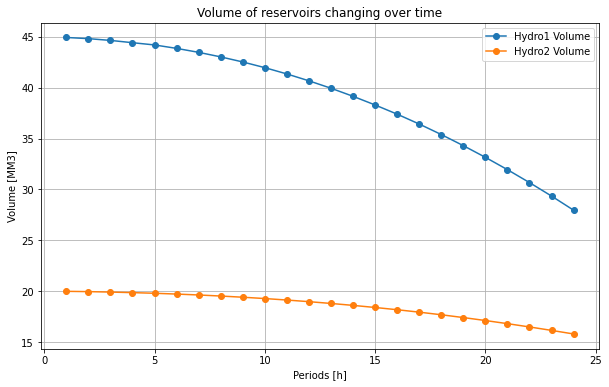

In [168]:
#RESERVOIR VOLUME

#Empty lists to be filled after solve for plotting:
volume_hydro1 = []
volume_hydro2 = []

# Extract and store the volume values for Hydro1 and Hydro2
for period in model.periods:
    volume_hydro1.append(model.v['Hydro1', period].value)
    volume_hydro2.append(model.v['Hydro2', period].value)

plt.figure(figsize=(10, 6))
plt.plot(model.periods, volume_hydro1, label='Hydro1 Volume', marker='o', linestyle='-')
plt.plot(model.periods, volume_hydro2, label='Hydro2 Volume', marker='o', linestyle='-')
plt.xlabel('Periods [h]')
plt.ylabel('Volume [MM3]')
plt.title('Volume of reservoirs changing over time')
plt.legend()
plt.grid(True)
plt.show()

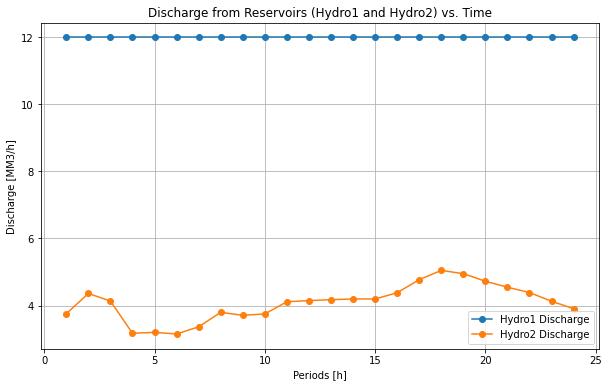

In [169]:
#RESERVOIR DISCHARGE
# Create empty lists to store discharge values for Hydro1 and Hydro2
discharge_hydro1 = []
discharge_hydro2 = []

# Extract and store the discharge values for Hydro1 and Hydro2
for period in model.periods:
    discharge_hydro1.append(model.q['Hydro1', period].value)
    discharge_hydro2.append(model.q['Hydro2', period].value)

# Plot the discharge vs. time for Hydro1 and Hydro2
plt.figure(figsize=(10, 6))
plt.plot(model.periods, discharge_hydro1, label='Hydro1 Discharge', marker='o', linestyle='-')
plt.plot(model.periods, discharge_hydro2, label='Hydro2 Discharge', marker='o', linestyle='-')
plt.xlabel('Periods [h]')
plt.ylabel('Discharge [MM3/h]')
plt.title('Discharge from Reservoirs (Hydro1 and Hydro2) vs. Time')
plt.legend()
plt.grid(True)
plt.show()

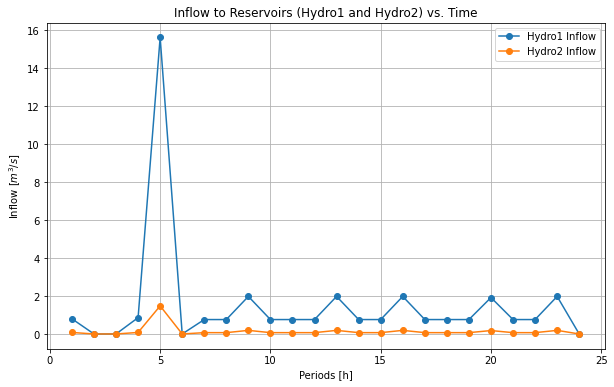

In [170]:
#RESERVOIR INFLOW
inflow_hydro1 = []
inflow_hydro2 = []

for period in model.periods:
    inflow_hydro1.append(model.inflow1[period])
    inflow_hydro2.append(model.inflow2[period])  

plt.figure(figsize=(10, 6))
plt.plot(model.periods, inflow_hydro1, label='Hydro1 Inflow', marker='o', linestyle='-')
plt.plot(model.periods, inflow_hydro2, label='Hydro2 Inflow', marker='o', linestyle='-')
plt.xlabel('Periods [h]')
plt.ylabel('Inflow [$m^3/s$]')  # Update the label if the units are different
plt.title('Inflow to Reservoirs (Hydro1 and Hydro2) vs. Time')
plt.legend()
plt.grid(True)
plt.show()

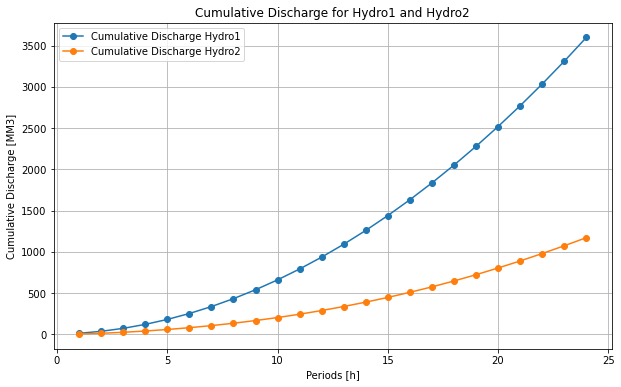

In [171]:
# Create empty lists to store cumulative discharge values
cumulative_q_hydro1 = []
cumulative_q_hydro2 = []

# Iterate over the periods to calculate cumulative discharge for Hydro1 and Hydro2
for j in model.periods:
    cumulative_q_hydro1.append(sum(model.cumulative_q['Hydro1', k].value for k in range(1, j + 1)))
    cumulative_q_hydro2.append(sum(model.cumulative_q['Hydro2', k].value for k in range(1, j + 1)))

# Plot cumulative discharge for Hydro1 and Hydro2
plt.figure(figsize=(10, 6))
plt.plot(model.periods, cumulative_q_hydro1, label='Cumulative Discharge Hydro1', linestyle='-', marker='o')
plt.plot(model.periods, cumulative_q_hydro2, label='Cumulative Discharge Hydro2', linestyle='-', marker='o')

plt.xlabel('Periods [h]')
plt.ylabel('Cumulative Discharge [MM3]')
plt.legend()
plt.grid(True)
plt.title('Cumulative Discharge for Hydro1 and Hydro2')
plt.show()


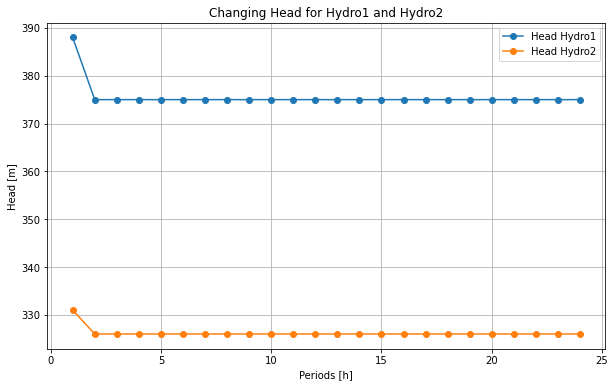

In [172]:
# Create empty lists to store head values
head_hydro1_values = []
head_hydro2_values = []

# Iterate over the periods to get head values for Hydro1 and Hydro2
for j in model.periods:
    head_hydro1_values.append(model.h['Hydro1', j].value)
    head_hydro2_values.append(model.h['Hydro2', j].value)

# Plot head values for Hydro1 and Hydro2
plt.figure(figsize=(10, 6))
plt.plot(model.periods, head_hydro1_values, label='Head Hydro1', linestyle='-', marker='o')
plt.plot(model.periods, head_hydro2_values, label='Head Hydro2', linestyle='-', marker='o')

plt.xlabel('Periods [h]')
plt.ylabel('Head [m]')
plt.legend()
plt.grid(True)
plt.title('Changing Head for Hydro1 and Hydro2')
plt.show()


### Useful code for later 

In [ ]:
#OBTAIN DICTIONARY VALUES THAT CAN BE USED IN PARAMETER MODELLIGN

a = market_prices_h
values = []
for value in a.values():
    values.append(value)
print(values)

#THIS CODE IS REDUNDANT, SPECIFY THE KEY AS model.periods INSTEAD!!

[26.33, 26.43, 26.1, 24.7, 24.74, 24.67, 24.98, 25.61, 25.48, 25.54, 26.07, 26.12, 26.16, 26.19, 26.19, 26.46, 27.03, 27.43, 27.29, 26.96, 26.7, 26.47, 26.09, 25.77]


In [ ]:
input_data_inflow = read_csv_data('data/Data_inflow.csv')
columns = ['Ormsetvatn', 'Buavatn']
inflow = convert_to_dict(input_data_inflow, start, end, 'H',columns)


display(input_data_inflow)
display(inflow)

,Ormsetvatn,Buavatn,Solar
Date,,,
2018-01-01 00:00:00,0.80,0.08,0.0
2018-01-01 01:00:00,0.00,0.00,0.0
2018-01-01 02:00:00,0.00,0.00,0.0
2018-01-01 03:00:00,0.86,0.08,0.0
2018-01-01 04:00:00,15.63,1.48,0.0
...,...,...,...
2022-12-31 19:00:00,0.00,0.00,0.0
2022-12-31 20:00:00,0.00,0.00,0.0
2022-12-31 21:00:00,0.00,0.00,0.0


[{1: 0.8,
  2: 0.0,
  3: 0.0,
  4: 0.86,
  5: 15.63,
  6: 0.0,
  7: 0.76,
  8: 0.76,
  9: 1.98,
  10: 0.76,
  11: 0.76,
  12: 0.76,
  13: 1.98,
  14: 0.76,
  15: 0.76,
  16: 1.98,
  17: 0.76,
  18: 0.76,
  19: 0.76,
  20: 1.92,
  21: 0.76,
  22: 0.76,
  23: 1.98,
  24: 0.0},
 {1: 0.08,
  2: 0.0,
  3: 0.0,
  4: 0.08,
  5: 1.48,
  6: 0.0,
  7: 0.07,
  8: 0.07,
  9: 0.19,
  10: 0.07,
  11: 0.07,
  12: 0.07,
  13: 0.19,
  14: 0.07,
  15: 0.07,
  16: 0.19,
  17: 0.07,
  18: 0.07,
  19: 0.07,
  20: 0.18,
  21: 0.07,
  22: 0.07,
  23: 0.19,
  24: 0.0}]

In [ ]:
def dataframe_to_dict(df):
    result = [df[col_name].to_dict() for col_name in df.columns]
    return result

# Example usage:
import pandas as pd

# Sample DataFrame
data = {
    'Ormsetvatn': [0.80, 0.00, 0.00, 0.86, 15.63],
    'Buavatn': [0.08, 0.00, 0.00, 0.08, 1.48],
    'Solar': [0.0, 0.0, 0.0, 0.0, 0.0]
}
df = pd.DataFrame(data)

result_list = dataframe_to_dict(df)
print(result_list)



[{0: 0.8, 1: 0.0, 2: 0.0, 3: 0.86, 4: 15.63}, {0: 0.08, 1: 0.0, 2: 0.0, 3: 0.08, 4: 1.48}, {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}]
